## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
SAVE_BEST_ONLY = [False, True]

In [7]:
#使用迴圈建立不同的帶不同參數模型並訓練
import itertools
from keras.callbacks import ModelCheckpoint

results = {}
for save_best in itertools.product(SAVE_BEST_ONLY):
  
    keras.backend.clear_session() # 把舊的 Graph 清掉
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              callbacks=[ModelCheckpoint(filepath="./tmp.h5",  monitor="val_loss", save_best_only=save_best)],
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "save_best_only(%s)" % (str(save_best))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

# final model
model.save("final.h5")
model.save_weights("weights.h5")

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512 

50000/50000 [==============================] - 8s 161us/step - loss: 0.5392 - accuracy: 0.8457 - val_loss: 1.6271 - val_accuracy: 0.4970
Epoch 47/50
50000/50000 [==============================] - 9s 189us/step - loss: 0.5224 - accuracy: 0.8520 - val_loss: 1.6392 - val_accuracy: 0.4942
Epoch 48/50
50000/50000 [==============================] - 12s 248us/step - loss: 0.5046 - accuracy: 0.8593 - val_loss: 1.6553 - val_accuracy: 0.4934
Epoch 49/50
50000/50000 [==============================] - 9s 182us/step - loss: 0.4895 - accuracy: 0.8650 - val_loss: 1.6883 - val_accuracy: 0.4947
Epoch 50/50
50000/50000 [==============================] - 10s 208us/step - loss: 0.4717 - accuracy: 0.8719 - val_loss: 1.6904 - val_accuracy: 0.4957
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
__________________________________________________

50000/50000 [==============================] - 8s 169us/step - loss: 0.6510 - accuracy: 0.8020 - val_loss: 1.5648 - val_accuracy: 0.4938
Epoch 42/50
50000/50000 [==============================] - 8s 161us/step - loss: 0.6328 - accuracy: 0.8087 - val_loss: 1.5794 - val_accuracy: 0.4913
Epoch 43/50
50000/50000 [==============================] - 8s 166us/step - loss: 0.6140 - accuracy: 0.8151 - val_loss: 1.5805 - val_accuracy: 0.4924
Epoch 44/50
50000/50000 [==============================] - 9s 172us/step - loss: 0.5979 - accuracy: 0.8216 - val_loss: 1.5913 - val_accuracy: 0.4954
Epoch 45/50
50000/50000 [==============================] - 10s 204us/step - loss: 0.5814 - accuracy: 0.8286 - val_loss: 1.5991 - val_accuracy: 0.4990
Epoch 46/50
50000/50000 [==============================] - 9s 174us/step - loss: 0.5655 - accuracy: 0.8336 - val_loss: 1.6225 - val_accuracy: 0.4898
Epoch 47/50
50000/50000 [==============================] - 8s 167us/step - loss: 0.5479 - accuracy: 0.8401 - val_loss

10000/10000 [==============================] - 2s 154us/step


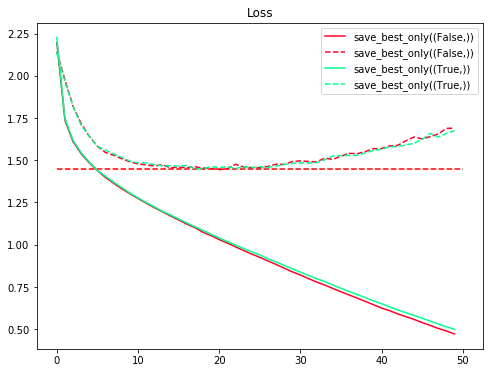

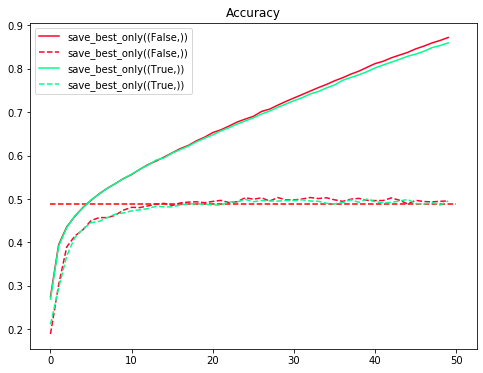

In [9]:
# Load back model
ldbak_model = keras.models.load_model("./tmp.h5")
loss_loadback, acc_loadback = ldbak_model.evaluate(x_test, y_test)

import matplotlib.pyplot as plt
%matplotlib inline

NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.title("Accuracy")
plt.legend()
plt.show()

In [17]:
from sklearn.metrics import accuracy_score

# final model
final_model = keras.models.load_model("./final.h5")
final_model_y = final_model.predict(x_test)
final_model_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=final_model_y.argmax(axis=-1))
print("final_model Accuracy: %.3f" % final_model_acc)

# ldbak model
ldbak_model = keras.models.load_model("./tmp.h5")
ldbak_model_y = ldbak_model.predict(x_test)
ldbak_model_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=ldbak_model_y.argmax(axis=-1))
print("ldbak_model Accuracy: %.3f" % ldbak_model_acc)

# ldWeight model
ldWeg_model = build_mlp(input_shape=x_train.shape[1:])
ldWeg_model.load_weights("./weights.h5")
ldWeg_model_y = ldWeg_model.predict(x_test)
ldWeg_model_acc = accuracy_score(y_true=y_test.argmax(axis=-1), y_pred=ldWeg_model_y.argmax(axis=-1))
print("ldWeg_model Accuracy: %.3f" % ldWeg_model_acc)

final_model Accuracy: 0.496
ldbak_model Accuracy: 0.489
ldWeg_model Accuracy: 0.496
